<h1><center><a href="https://tblock.github.io/10kGNAD/">Ten Thousand German News Articles Dataset</a></center></h1>
<h2><center>NLP Project work, FHNW Brugg</center></h2>
<h3><center>BERT Classifier</center></h3>
<h4><center>Claudio Schmidli</center></h4>
<h4><center>30.06.2023</center></h4>


<p align="justify">
In this notebook, I am going to train a BERT classifier on the 'Ten Thousand German News Articles Dataset'. My plan is to use transfer learning with the bert-base-german-cased BERT model. Initially, I will freeze all layers except the model head and focus on training just the head. Once this is done, I will move on to the second step where I unfreeze all the layers. This step is crucial for fine-tuning the entire model to better fit our specific dataset. After fine-tuning, I will evaluate the model's performance to see how well it classifies German news articles.
</p>

<p align="justify">

</p>

<p align="justify">


<p align="justify">

</p>



## 1. Setup the notebook


In [2]:
%%capture
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Colab Notebooks/NLP/Project/'
!pip install 'fhnw-nlp-utils>=0.8.0,<0.9.0'

#from fhnw.nlp.utils.processing import parallelize_dataframe
#from fhnw.nlp.utils.processing import is_iterable
from fhnw.nlp.utils.storage import download
#from fhnw.nlp.utils.storage import save_dataframe
from fhnw.nlp.utils.storage import load_dataframe
from fhnw.nlp.utils.preprocess import preprocess
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import re
import matplotlib.pyplot as plt
from transformers import BertTokenizer
from tqdm.notebook import tqdm
tqdm.pandas()
import pickle
import tensorflow as tf
from transformers import TFBertModel
from sklearn.utils.class_weight import compute_class_weight
import sys
from modules.plotmodels import PlotLearning, plot_learning_schedule, macro_f1_score
from modules.models import build_bert_model, lrfn
#from modules.data import DataHandler
from keras import backend as K
import os
from sklearn.metrics import f1_score

## 2. Load the data

In [3]:
class DataHandler:
    def __init__(self, cache, label_column, feature_column, MAX_TOKEN_LEN):

        self.cache = cache

        # Load train set
        file = f"{self.cache}raw/train.parq"
        download("https://drive.switch.ch/index.php/s/mRnuzx4BLpMLqyz/download", file)
        self.train_df = load_dataframe(file)

        # Load test set
        file = f"{self.cache}raw/test.parq"
        download("https://drive.switch.ch/index.php/s/DKUnZraeGp3EIK3/download", file)
        self.test_df = load_dataframe(file)

        #Define feature and label column
        self.label_column = label_column
        self.feature_column = feature_column

        #Clean the data
        self.train_df[feature_column] = self.train_df[feature_column].map(DataHandler._clean_text)
        self.test_df[feature_column] = self.test_df[feature_column].map(DataHandler._clean_text)


        #Save text lengths (after cleaning) into variables (can e.g. be used for plotting later)
        self.dist_text_len_train = self.train_df[feature_column].map(len)
        self.dist_text_len_test = self.test_df[feature_column].map(len)

        #Define label <--> index mapping
        self.create_label_mapping()

        #Test train split
        train_df, val_df = self.train_val_split(self.train_df)

        #Feature label split
        self.X_train, self.y_train = self.feature_label_split(train_df)
        self.X_test, self.y_test = self.feature_label_split(self.test_df)
        self.X_val, self.y_val = self.feature_label_split(val_df)

        #tokenize
        self.MAX_TOKEN_LEN=MAX_TOKEN_LEN
        self.tokenizer = BertTokenizer.from_pretrained("bert-base-german-cased")
        self.X_train = np.array([self._tokenize_text(text) for text in tqdm(self.X_train)])
        self.X_test = np.array([self._tokenize_text(text) for text in tqdm(self.X_test)])
        self.X_val = np.array([self._tokenize_text(text) for text in tqdm(self.X_val)])

        #Get indices of labels
        self.y_train_1hot = self.one_hot_encode(self.y_train)
        self.y_test_1hot = self.one_hot_encode(self.y_test)
        self.y_val_1hot = self.one_hot_encode(self.y_val)

        #Calculate class weights
        self.calculate_class_weights()


    @staticmethod
    def _clean_text(text):
        """
            - remove any html tags (< /br> often found)
            - Keep only ASCII + European Chars and whitespace, no digits
            - remove single letter chars
            - convert all whitespaces (tabs etc.) to single wspace
        """
        RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
        RE_TAGS = re.compile(r"<[^>]+>")
        RE_ASCII = re.compile(r"[^A-Za-zÀ-ž,.!? ]", re.IGNORECASE)
        RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž,.!?]\b", re.IGNORECASE)

        text = re.sub(RE_TAGS, " ", text)
        text = re.sub(RE_ASCII, " ", text)
        text = re.sub(RE_SINGLECHAR, " ", text)
        text = re.sub(RE_WSPACE, " ", text)
        return text


    def plt_text_len_dist(self):
      # Create a figure and a set of subplots
      fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

      # Histogram for data.dist_text_len_train
      axs[0].hist(self.dist_text_len_train, bins=50, rwidth=0.8)
      axs[0].set_title('Train Set')
      axs[0].set_xlabel('Text Length')
      axs[0].set_ylabel('Frequency')

      # Histogram for data.dist_text_len_test
      axs[1].hist(self.dist_text_len_test, bins=50, rwidth=0.8)
      axs[1].set_title('Test Set')
      axs[1].set_xlabel('Text Length')
      axs[1].set_ylabel('Frequency')

      # Set a title for the entire figure
      #plt.suptitle('Text Lengths')

      # Adjust layout for better display
      plt.tight_layout(rect=[0, 0.03, 1, 0.95])

      # Show the plot
      plt.show()

    def _tokenize_text(self, text):
        encoded = self.tokenizer.encode_plus(
        text=text,
        add_special_tokens=True,  # Add `[CLS]` and `[SEP]`
        max_length=self.MAX_TOKEN_LEN,  # Max length to truncate/pad
        padding='max_length',  # Pad sentence to max length
        return_attention_mask=False,  # attention mask not needed for our task
        return_token_type_ids=False,
        truncation=True, )
        return encoded['input_ids']

    def train_val_split(self, train_df, test_size=0.2, random_state=42):
        return train_test_split(train_df,
                                test_size=test_size,
                                random_state=random_state,
                                shuffle=True,
                                stratify=train_df[self.label_column])

    def feature_label_split(self, data):
      X, y = data[self.feature_column], data[self.label_column]
      return  X, y


    def create_label_mapping(self):
        data_all = pd.concat([self.train_df, self.test_df])
        self.label_to_index = {label: index for index, label in enumerate(data_all[self.label_column].unique())}
        self.index_to_label = {index: label for label, index in self.label_to_index.items()}

    def one_hot_encode(self, labels):
        return tf.keras.utils.to_categorical([self.label_to_index[label] for label in labels], num_classes=len(self.label_to_index))

    def create_batched_datasets(self, EPOCHS, BATCH_SIZE, batches_in_train = -1):

        #Only use a part of the data for the training in case batches_in_train > 0
        if(batches_in_train > 0):
          X_train = self.X_train[:batches_in_train*BATCH_SIZE] # 4*32 = 128
          y_train_1hot = self.y_train_1hot[:batches_in_train*BATCH_SIZE]
        else:
           X_train = self.X_train
           y_train_1hot = self.y_train_1hot

        self.train_len = len(X_train)

        self.train_dataset = (tf.data.Dataset.from_tensor_slices((X_train, y_train_1hot))
                    .shuffle(buffer_size=len(X_train), reshuffle_each_iteration=True)
                    .repeat(EPOCHS)
                    .batch(BATCH_SIZE))
        self.val_dataset = (tf.data.Dataset.from_tensor_slices((self.X_val, self.y_val_1hot))
                    .batch(BATCH_SIZE))

    def predictions_to_labels(self, predictions, return_labels=True):
        """
        Converts model predictions to either text class labels or their indices.

        Parameters:
        predictions (array-like): The output array from model prediction.
        return_labels (bool): If True, returns text labels; otherwise returns indices.

        Returns:
        An array of text labels or indices based on the predictions.
        """
        # Get the index of the maximum value in each prediction vector (highest probability)
        predicted_indices = np.argmax(predictions, axis=1)

        if return_labels:
            # Convert indices to text labels
            return [self.index_to_label[idx] for idx in predicted_indices]
        else:
            # Return indices
            return predicted_indices

    def calculate_class_weights(self):
        # Convert one-hot encoded labels back to original class labels
        original_labels = np.argmax(self.y_train_1hot, axis=1)

        # Compute class weights
        class_weights = compute_class_weight(
            'balanced',
            classes=np.unique(original_labels),
            y=original_labels
        )

        # Map the computed weights to the corresponding class indices
        self.class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

    def save_class_instance(self, name='preprocessed_data'):
        # Only save the data that are not tensorflow objects
        # First, temporarily remove TensorFlow objects
        if hasattr(self, 'train_dataset') and hasattr(self, 'val_dataset'):
          train_dataset_tmp, val_dataset_tmp = self.train_dataset, self.val_dataset
        self.train_dataset, self.val_dataset = None, None

        try:
            with open(os.path.join(self.cache, f'{name}.pkl'), 'wb') as file:
                pickle.dump(self, file)
            #print("Class instance saved successfully.")
        except Exception as e:
            print(f"Error saving class instance: {e}")

        # Restore the TensorFlow objects
        if 'train_dataset_tmp' in locals() and 'val_dataset_tmp' in locals():
          self.train_dataset, self.val_dataset = train_dataset_tmp, val_dataset_tmp

    @staticmethod
    def load_class_instance(path='data/raw/', name='preprocessed_data'):
        # Load the class instance using pickle
        try:
            with open(os.path.join(path, f'{name}.pkl'), 'rb') as file:
                loaded_data = pickle.load(file)
            #print("Class instance loaded successfully.")
        except Exception as e:
            print(f"Error loading class instance: {e}")
            return None
        return loaded_data

    def _get_class_counts(self, data: pd.Series) -> pd.Series:
        val_counts = data.value_counts().sort_index(ascending=False)
        val_counts = val_counts / np.sum(val_counts)
        return val_counts

    def plt_label_distribution(self):
      fig, axs = plt.subplots(1, 2, figsize=(12, 4))

      self._get_class_counts(self.train_df[self.label_column]).plot(kind='barh', title='Distribution of class labels train set', ax=axs[0])
      self._get_class_counts(self.test_df[self.label_column]).plot(kind='barh', title='Distribution of class test set', ax=axs[1])

      plt.tight_layout()
      plt.show()

    def print_class_weights(self):
      print("Class weights:")
      for key, value in self.class_weights_dict.items():
        print(f"{self.index_to_label[key]:<{15}}", value)

def load_data(MAX_TOKEN_LEN, CACHE, PREPROC_DATA_CACHE):
  #Load data from cache if present
  if os.path.isfile(f'{CACHE}{PREPROC_DATA_CACHE}.pkl'):
    data = DataHandler.load_class_instance(path = CACHE, name = PREPROC_DATA_CACHE)
  #Create new data object in case there is nothing in the cache
  else:
    data = DataHandler(cache = CACHE, label_column="label", feature_column="text_original", MAX_TOKEN_LEN=MAX_TOKEN_LEN)
  data.save_class_instance(name=PREPROC_DATA_CACHE) #Note: Batches are not saved!
  return data


# Prepare and load data for tensorflow

In [4]:
MAX_TOKEN_LEN = 192#512
CACHE = 'data/'
PREPROC_DATA_CACHE = f'preprocessed_data_{MAX_TOKEN_LEN}_tokens'
data = load_data(MAX_TOKEN_LEN, CACHE, PREPROC_DATA_CACHE)

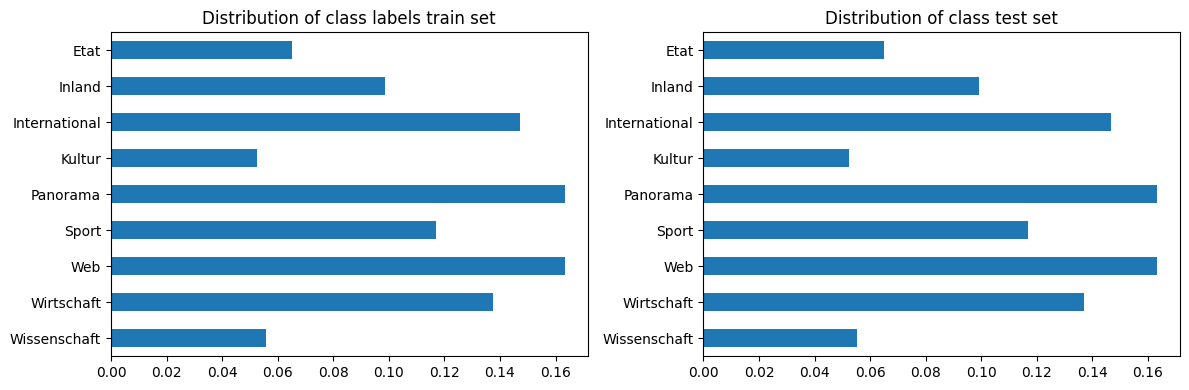

In [5]:
data.plt_label_distribution()

In [4]:
data.print_class_weights()

Class weights:
Sport           0.9500321130378934
Kultur          2.117983963344788
Web             0.6808432293105036
Wirtschaft      0.8088363954505686
Inland          1.1257229832572297
Etat            1.7084777084777085
International   0.7553104575163399
Panorama        0.6802796173657101
Wissenschaft    1.9897767016411083


The class weight I created with my DataHander class seem to make sense and are in agreement with the plot of the class distributions.

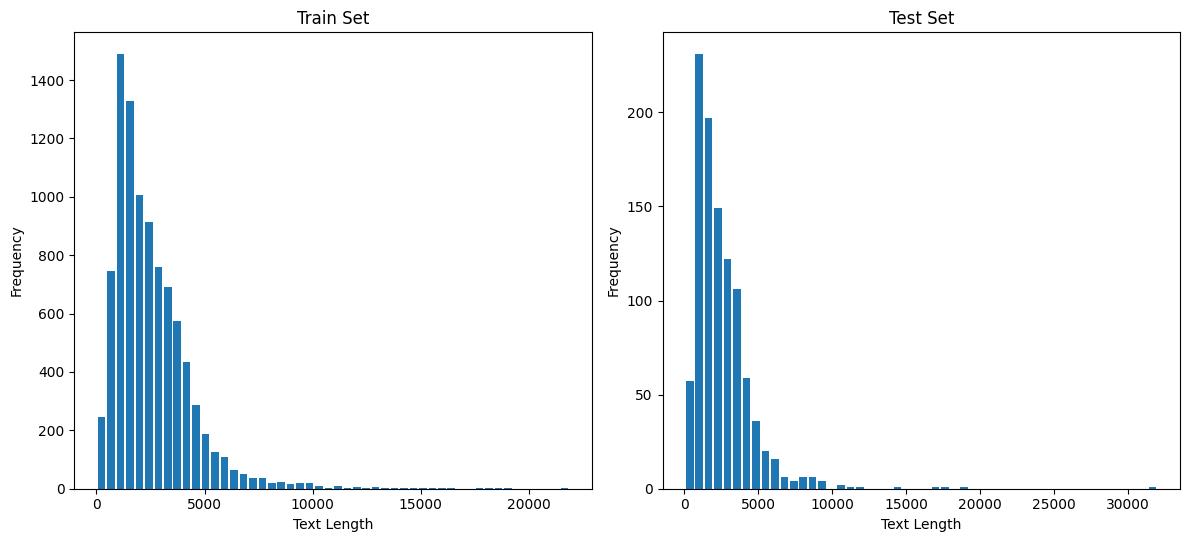

In [6]:
data.plt_text_len_dist()

# Bert Model 1

I start by training just eight batches on my BERT model, focusing initially on training only the custom classification head. This is to establish the initial weights for subsequent fine-tuning. Additiionally, I use class weights to handle the class imbalance.
#### Model Properties

<table>
  <tr>
    <th>Property</th>
    <th>Value</th>
  </tr>
  <tr>
    <td>Model</td>
    <td>Bert</td>
  </tr>
  <tr>
    <td>Number of Tokens</td>
    <td>192</td>
  </tr>
  <tr>
    <td>Weighted classes</td>
    <td>True</td>
  </tr>
  <tr>
    <td>Number of trained batches</td>
    <td>8</td>
  </tr>
  <tr>
    <td>Regularization (Dropout)</td>
    <td>False</td>
  </tr>
</table>

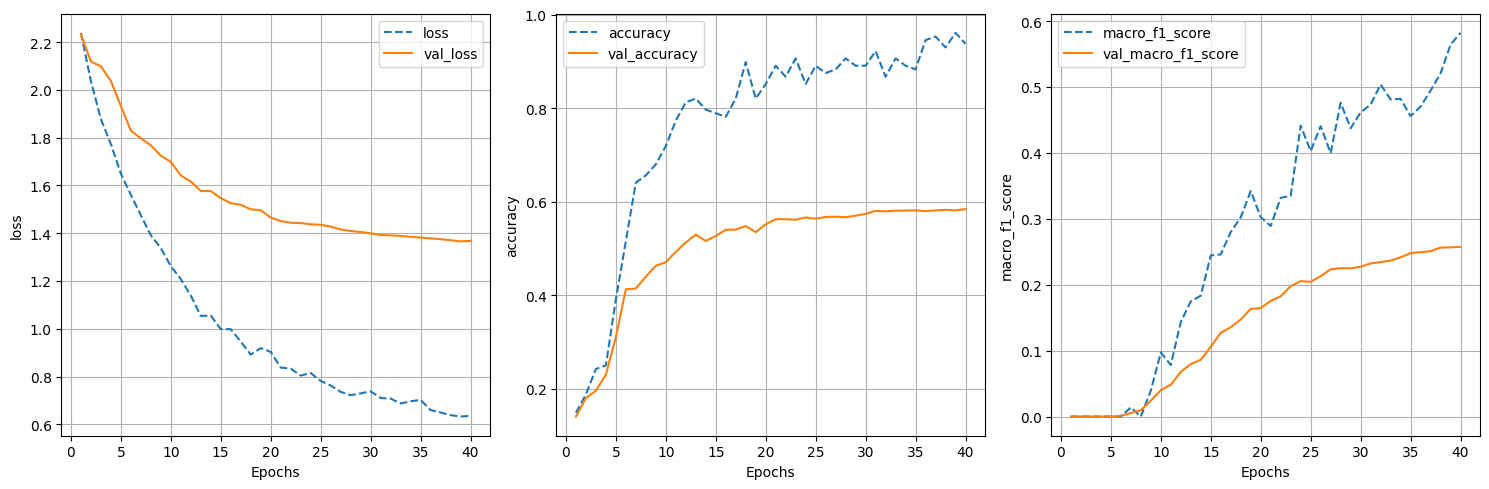

8/8 [==============================] - 10s 1s/step - loss: 0.6351 - accuracy: 0.9375 - macro_f1_score: 0.5823 - val_loss: 1.3678 - val_accuracy: 0.5841 - val_macro_f1_score: 0.2575 - lr: 2.2601e-04


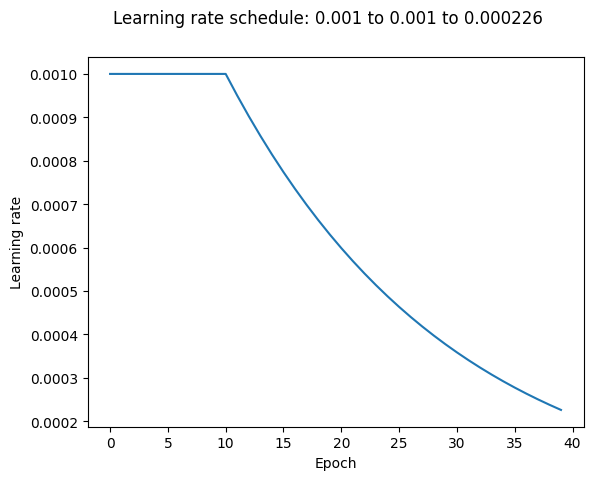

In [7]:
#Define batches and epoches
BATCH_SIZE = 16
EPOCHS = 40
NBR_OF_BATCHES = 8
data.create_batched_datasets(EPOCHS, BATCH_SIZE, batches_in_train = NBR_OF_BATCHES)
data.y_train_1hot
data.X_train
model_name = 'bert_8_batches_weighted'

#Define learning schedule
LR_START = 0.001
LR_MAX = 0.001
LR_MIN = 0.0000001
LR_RAMPUP_EPOCHS = 0
LR_SUSTAIN_EPOCHS = 10
LR_EXP_DECAY = 0.95

def lrfn(epoch):
        if epoch < LR_RAMPUP_EPOCHS:
            lr = (
                LR_MAX - LR_START
            ) / LR_RAMPUP_EPOCHS * epoch + LR_START
        elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
            lr = LR_MAX
        else:
            lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY ** (
                epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS
            ) + LR_MIN
        return lr

plot_learning_schedule(EPOCHS, lrfn)
#Build a Bert model
def build_bert_model(max_len):
    """ add binary classification to pretrained model
    """

    input_word_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")

    bert_model = TFBertModel.from_pretrained("bert-base-german-cased", name='pre-trained_bert')
    encoder_outputs = bert_model(input_word_ids)

    last_hidden_state = encoder_outputs[0]
    pooler_output = encoder_outputs[1]
    cls_embedding = pooler_output

    #dropout = tf.keras.layers.Dropout(0.1)(cls_embedding)
    stack = tf.keras.layers.Dense(9, name = "fc")(cls_embedding)#dropout

    output = tf.keras.layers.Activation('softmax')(stack)
    model = tf.keras.models.Model(inputs=input_word_ids, outputs=output)
    return model

model = build_bert_model(max_len=MAX_TOKEN_LEN)
model.get_layer("pre-trained_bert").trainable = False
model.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=LR_START)
loss = "categorical_crossentropy"

model.compile(optimizer, loss=loss, metrics=["accuracy", macro_f1_score])

lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose= 0)

checkpoint_path= f"{CACHE}models/{model_name}"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)


hist_overfit = model.fit(
    data.train_dataset,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    steps_per_epoch = int(np.floor((data.train_len/BATCH_SIZE))),
    validation_data=data.val_dataset,
    verbose=1,
    class_weight=data.class_weights_dict,
    callbacks=[
               #tf.keras.callbacks.EarlyStopping(monitor="val_loss", verbose=1, patience=1, restore_best_weights=True),
               model_checkpoint_callback,
               lr_callback,
               PlotLearning(),
               #tf.keras.callbacks.TensorBoard(f'logs/{datetime.now()}')
               ],
)
plot_learning_schedule(EPOCHS, lrfn)

As you can see, the model is overfitting.

# Bert Model 2
Next, I tried to fix this overfitting problem. What I did was add a dropout of 0.1 right before the fully connected layer in my model. It looks like this helped a bit. The results got a little better. And I saw this not just on 8 batches, but when I tested on the full data too.
#### Model Properties

<table>
  <tr>
    <th>Property</th>
    <th>Value</th>
  </tr>
  <tr>
    <td>Model</td>
    <td>Bert</td>
  </tr>
  <tr>
    <td>Number of Tokens</td>
    <td>192</td>
  </tr>
  <tr>
    <td>Weighted classes</td>
    <td>True</td>
  </tr>
  <tr>
    <td>Number of trained batches</td>
    <td>8</td>
  </tr>
  <tr>
    <td>Regularization (Dropout)</td>
    <td>True</td>
  </tr>
</table>

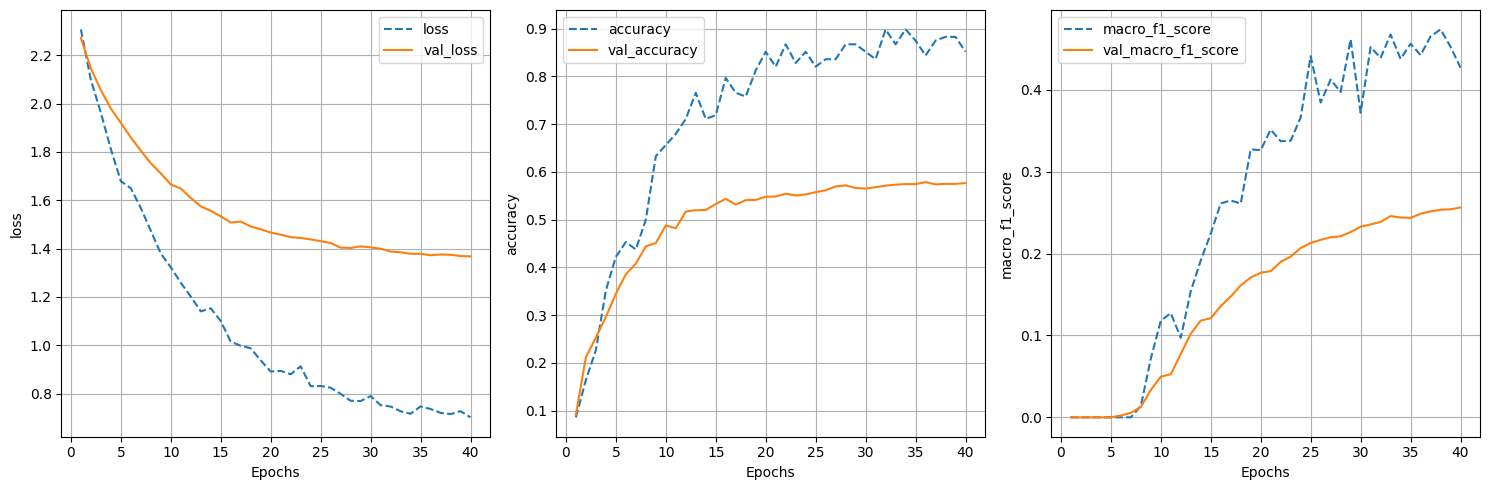

8/8 [==============================] - 12s 2s/step - loss: 0.7021 - accuracy: 0.8516 - macro_f1_score: 0.4270 - val_loss: 1.3678 - val_accuracy: 0.5765 - val_macro_f1_score: 0.2563 - lr: 2.2601e-04


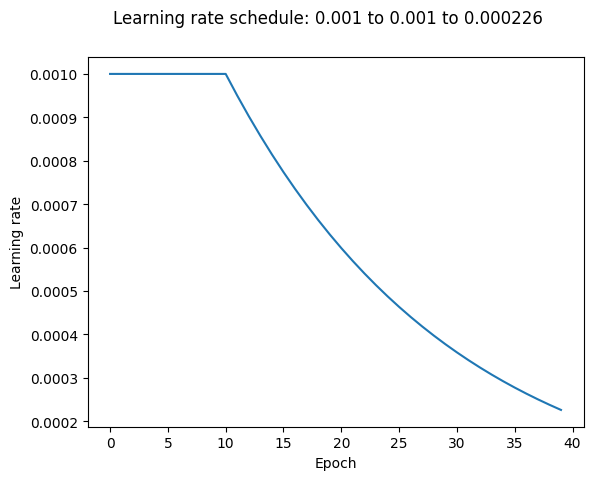

In [11]:
#Define batches and epoches
BATCH_SIZE = 16
EPOCHS = 40
NBR_OF_BATCHES = 8
data.create_batched_datasets(EPOCHS, BATCH_SIZE, batches_in_train = NBR_OF_BATCHES)
data.y_train_1hot
data.X_train
model_name = 'bert_8_batches_weighted_dropout'

#Define learning schedule
LR_START = 0.001
LR_MAX = 0.001
LR_MIN = 0.0000001
LR_RAMPUP_EPOCHS = 0
LR_SUSTAIN_EPOCHS = 10
LR_EXP_DECAY = 0.95

def lrfn(epoch):
        if epoch < LR_RAMPUP_EPOCHS:
            lr = (
                LR_MAX - LR_START
            ) / LR_RAMPUP_EPOCHS * epoch + LR_START
        elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
            lr = LR_MAX
        else:
            lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY ** (
                epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS
            ) + LR_MIN
        return lr

plot_learning_schedule(EPOCHS, lrfn)
#Build a Bert model
def build_bert_model(max_len):
    """ add binary classification to pretrained model
    """

    input_word_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")

    bert_model = TFBertModel.from_pretrained("bert-base-german-cased", name='pre-trained_bert')
    encoder_outputs = bert_model(input_word_ids)

    last_hidden_state = encoder_outputs[0]
    pooler_output = encoder_outputs[1]
    cls_embedding = pooler_output

    dropout = tf.keras.layers.Dropout(0.1)(cls_embedding)
    stack = tf.keras.layers.Dense(9, name = "fc")(dropout )

    output = tf.keras.layers.Activation('softmax')(stack)
    model = tf.keras.models.Model(inputs=input_word_ids, outputs=output)
    return model

model = build_bert_model(max_len=MAX_TOKEN_LEN)
model.get_layer("pre-trained_bert").trainable = False
model.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=LR_START)
loss = "categorical_crossentropy"

model.compile(optimizer, loss=loss, metrics=["accuracy", macro_f1_score])

lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose= 0)

checkpoint_path= f"{CACHE}models/{model_name}"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)


hist_overfit = model.fit(
    data.train_dataset,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    steps_per_epoch = int(np.floor((data.train_len/BATCH_SIZE))),
    validation_data=data.val_dataset,
    verbose=1,
    class_weight=data.class_weights_dict,
    callbacks=[
               #tf.keras.callbacks.EarlyStopping(monitor="val_loss", verbose=1, patience=1, restore_best_weights=True),
               model_checkpoint_callback,
               lr_callback,
               PlotLearning(),
               #tf.keras.callbacks.TensorBoard(f'logs/{datetime.now()}')
               ],
)
plot_learning_schedule(EPOCHS, lrfn)

It turned out then when using a dropout of 0.1 I get silightly better result. However, higher values give worse results.

# Bert Model 3
After performing many tests I realized that the class weights make the performance worse. So I decided to not use them. Somehow the model can handle the data imbalance it's own.
#### Model Properties

<table>
  <tr>
    <th>Property</th>
    <th>Value</th>
  </tr>
  <tr>
    <td>Model</td>
    <td>Bert</td>
  </tr>
  <tr>
    <td>Number of Tokens</td>
    <td>192</td>
  </tr>
  <tr>
    <td>Weighted classes</td>
    <td>False</td>
  </tr>
  <tr>
    <td>Number of trained batches</td>
    <td>8</td>
  </tr>
  <tr>
    <td>Regularization (Dropout)</td>
    <td>True</td>
  </tr>
</table>

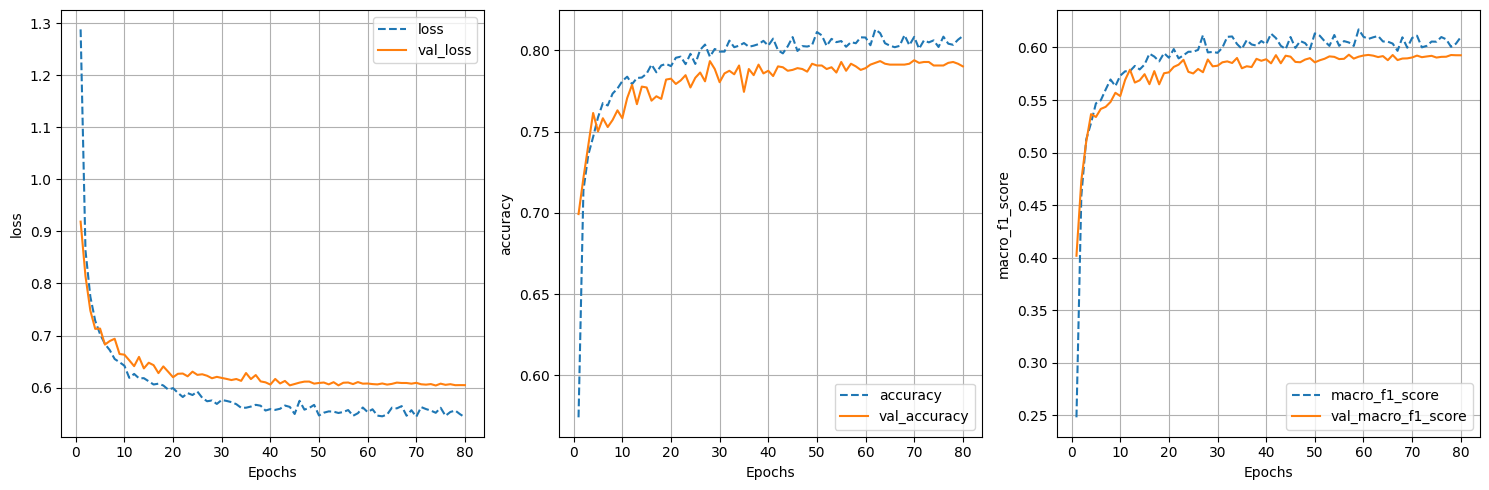

462/462 [==============================] - 50s 107ms/step - loss: 0.5430 - accuracy: 0.8088 - macro_f1_score: 0.6099 - val_loss: 0.6048 - val_accuracy: 0.7902 - val_macro_f1_score: 0.5926 - lr: 2.9133e-05


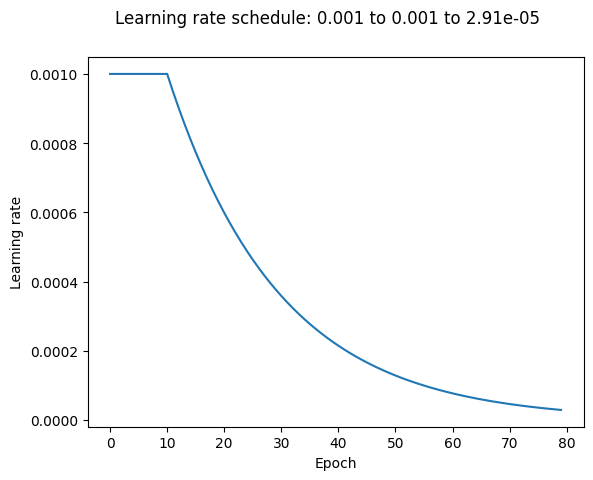

In [14]:
#Define batches and epoches
BATCH_SIZE = 16
EPOCHS = 80
NBR_OF_BATCHES = -1 #=all
data.create_batched_datasets(EPOCHS, BATCH_SIZE, batches_in_train = NBR_OF_BATCHES)
data.y_train_1hot
data.X_train
model_name = 'bert_all_batches_Not_weighted_dropout'

#Define learning schedule
LR_START = 0.001
LR_MAX = 0.001
LR_MIN = 0.0000001
LR_RAMPUP_EPOCHS = 0
LR_SUSTAIN_EPOCHS = 10
LR_EXP_DECAY = 0.95

def lrfn(epoch):
        if epoch < LR_RAMPUP_EPOCHS:
            lr = (
                LR_MAX - LR_START
            ) / LR_RAMPUP_EPOCHS * epoch + LR_START
        elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
            lr = LR_MAX
        else:
            lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY ** (
                epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS
            ) + LR_MIN
        return lr

plot_learning_schedule(EPOCHS, lrfn)
#Build a Bert model
def build_bert_model(max_len):
    """ add binary classification to pretrained model
    """

    input_word_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")

    bert_model = TFBertModel.from_pretrained("bert-base-german-cased", name='pre-trained_bert')
    encoder_outputs = bert_model(input_word_ids)

    last_hidden_state = encoder_outputs[0]
    pooler_output = encoder_outputs[1]
    cls_embedding = pooler_output

    dropout = tf.keras.layers.Dropout(0.1)(cls_embedding)
    stack = tf.keras.layers.Dense(9, name = "fc")(dropout )

    output = tf.keras.layers.Activation('softmax')(stack)
    model = tf.keras.models.Model(inputs=input_word_ids, outputs=output)
    return model

model = build_bert_model(max_len=MAX_TOKEN_LEN)
model.get_layer("pre-trained_bert").trainable = False
model.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=LR_START)
loss = "categorical_crossentropy"

model.compile(optimizer, loss=loss, metrics=["accuracy", macro_f1_score])

lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose= 0)

checkpoint_path= f"{CACHE}models/{model_name}"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)


hist_overfit = model.fit(
    data.train_dataset,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    steps_per_epoch = int(np.floor((data.train_len/BATCH_SIZE))),
    validation_data=data.val_dataset,
    verbose=1,
    #class_weight=data.class_weights_dict,
    callbacks=[
               #tf.keras.callbacks.EarlyStopping(monitor="val_loss", verbose=1, patience=1, restore_best_weights=True),
               model_checkpoint_callback,
               lr_callback,
               PlotLearning(),
               #tf.keras.callbacks.TensorBoard(f'logs/{datetime.now()}')
               ],
)
plot_learning_schedule(EPOCHS, lrfn)

#Bert model 4 - Finetuning
Now, I am going to unfreeze all the layers of my model and try fine-tuning it with a smaller learning rate. I plan to use a learning schedule that includes a warm-up phase, followed by a sustain phase, and then a decay phase.

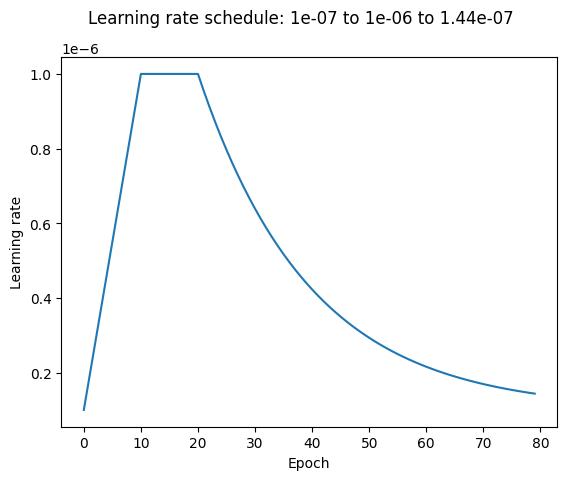

In [12]:
#Define learning schedule
LR_START = 0.0000001
LR_MAX =   0.000001
LR_MIN =   0.0000001
LR_RAMPUP_EPOCHS = 10
LR_SUSTAIN_EPOCHS = 10
LR_EXP_DECAY = 0.95

def lrfn(epoch):
        if epoch < LR_RAMPUP_EPOCHS:
            lr = (
                LR_MAX - LR_START
            ) / LR_RAMPUP_EPOCHS * epoch + LR_START
        elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
            lr = LR_MAX
        else:
            lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY ** (
                epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS
            ) + LR_MIN
        return lr

plot_learning_schedule(EPOCHS, lrfn)

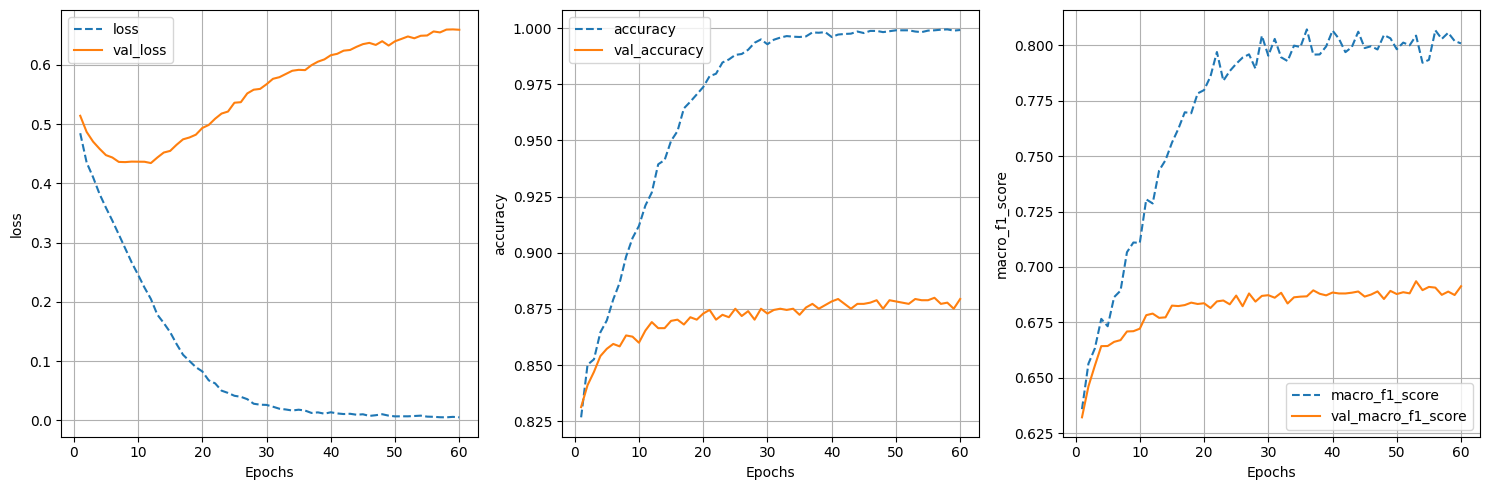

462/462 [==============================] - 114s 248ms/step - loss: 0.0052 - accuracy: 0.9992 - macro_f1_score: 0.8009 - val_loss: 0.6591 - val_accuracy: 0.8794 - val_macro_f1_score: 0.6913 - lr: 2.2175e-07


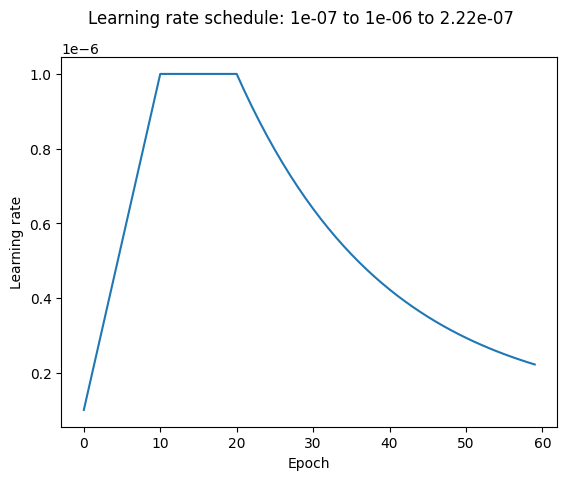

In [5]:
#Define batches and epoches
BATCH_SIZE = 16
EPOCHS = 60
NBR_OF_BATCHES = -1 #=all
data.create_batched_datasets(EPOCHS, BATCH_SIZE, batches_in_train = NBR_OF_BATCHES)
data.y_train_1hot
data.X_train
model_name = 'bert_all_batches_Not_weighted_dropout_finetune'

#Define learning schedule
LR_START = 0.0000001
LR_MAX =   0.000001
LR_MIN =   0.0000001
LR_RAMPUP_EPOCHS = 10
LR_SUSTAIN_EPOCHS = 10
LR_EXP_DECAY = 0.95

def lrfn(epoch):
        if epoch < LR_RAMPUP_EPOCHS:
            lr = (
                LR_MAX - LR_START
            ) / LR_RAMPUP_EPOCHS * epoch + LR_START
        elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
            lr = LR_MAX
        else:
            lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY ** (
                epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS
            ) + LR_MIN
        return lr

plot_learning_schedule(EPOCHS, lrfn)
def build_bert_model(max_len):
    """ add binary classification to pretrained model
    """

    input_word_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")

    bert_model = TFBertModel.from_pretrained("bert-base-german-cased", name='pre-trained_bert')
    encoder_outputs = bert_model(input_word_ids)

    last_hidden_state = encoder_outputs[0]
    pooler_output = encoder_outputs[1]
    cls_embedding = pooler_output

    dropout = tf.keras.layers.Dropout(0.1)(cls_embedding)
    stack = tf.keras.layers.Dense(9, name = "fc")(dropout )

    output = tf.keras.layers.Activation('softmax')(stack)
    model = tf.keras.models.Model(inputs=input_word_ids, outputs=output)
    return model

model = build_bert_model(max_len=MAX_TOKEN_LEN)
model.get_layer("pre-trained_bert").trainable = True ############################ True
model.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=LR_START)
loss = "categorical_crossentropy"
model.load_weights(f'{CACHE}models/bert_all_batches_Not_weighted_dropout', skip_mismatch=False, by_name=False, options=None) ###################### load weights

model.compile(optimizer, loss=loss, metrics=["accuracy", macro_f1_score])

lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose= 0)

checkpoint_path= f"{CACHE}models/{model_name}"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)


hist_overfit = model.fit(
    data.train_dataset,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    steps_per_epoch = int(np.floor((data.train_len/BATCH_SIZE))),
    validation_data=data.val_dataset,
    verbose=1,
    #class_weight=data.class_weights_dict,
    callbacks=[
               #tf.keras.callbacks.EarlyStopping(monitor="val_loss", verbose=1, patience=1, restore_best_weights=True),
               model_checkpoint_callback,
               lr_callback,
               PlotLearning(),
               #tf.keras.callbacks.TensorBoard(f'logs/{datetime.now()}')
               ],
)
plot_learning_schedule(EPOCHS, lrfn)

# Check the model performance on the test set

33/33 [==============================] - 8s 137ms/step


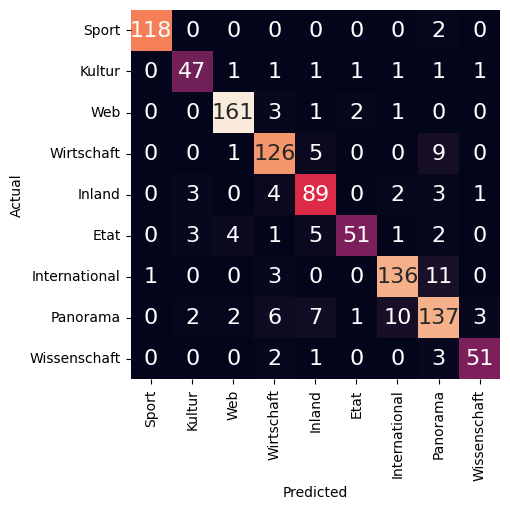

               precision    recall  f1-score   support

        Sport       0.99      0.98      0.99       120
       Kultur       0.85      0.87      0.86        54
          Web       0.95      0.96      0.96       168
   Wirtschaft       0.86      0.89      0.88       141
       Inland       0.82      0.87      0.84       102
         Etat       0.93      0.76      0.84        67
International       0.90      0.90      0.90       151
     Panorama       0.82      0.82      0.82       168
 Wissenschaft       0.91      0.89      0.90        57

     accuracy                           0.89      1028
    macro avg       0.89      0.88      0.89      1028
 weighted avg       0.89      0.89      0.89      1028



In [10]:
import seaborn as sn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
y_pred = model.predict(data.X_test)
y_pred_class = np.argmax(y_pred, axis=1)
y_test_class = np.argmax(data.y_test_1hot, axis=1)
cm = confusion_matrix(y_test_class, y_pred_class)
labels = list(data.label_to_index)
df_cm = pd.DataFrame(cm, labels, labels)
ax = sn.heatmap(df_cm, annot=True, annot_kws={'size': 16}, square=True, cbar=False, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print(classification_report(y_test_class, y_pred_class, target_names=labels))

After completing the fine-tuning process on my BERT model, I was able to achieve a macro F1 score of 0.89 on the test set. This result was particularly satisfying, as it reflected the effectiveness of the fine-tuning adjustments I made to the model.

# &#10132; F1 macro avg = 0.89